# **Interactive Viewer for Global Gridded Temperature & Salinity (1960–Present)** #

*What do six decades of global ocean data reveal about long-term change?*

For an interactive version of this page please visit the Google Colab:  
[<img src="https://colab.research.google.com/img/colab_favicon_256px.png" height="35px" align=CENTER> Open in Google Colab ](https://colab.research.google.com/drive/122NdAxBs2LriP21uAWRtpBBB7lcgreoZ)<br>
<sub>(To open link in new tab press Ctrl + click)</sub>

Alternatively this notebook can be opened with Binder by following the link:  
[Interactive Viewer for Global Gridded Temperature & Salinity (1960–Present)](https://mybinder.org/v2/gh/s4oceanice/literacy.s4oceanice/main?urlpath=%2Fdoc%2Ftree%2Fnotebooks_binder%2Foceanice_cora_point.ipynb)

**Purpose**

This notebook builds an **interactive map interface (via WMS)** to browse **monthly gridded fields of ocean temperature and salinity** derived from in-situ observations.
Users can:

* Select **time, depth and variable** (temperature or salinity).

* Render global maps interactively using the **ncWMS service**.

* Extract **time series** and **vertical profiles** at chosen coordinates.

It is designed for:

* Fast visual inspection of long records (1960 → today).

* Quick comparisons across depths.

* Teaching/demonstration of WMS and ERDDAP capabilities.

**Data sources**

The layers come from the **Copernicus Marine Service product** [INSITU_GLO_PHY_TS_OA_MY_013_052](https://https://www.seanoe.org/data/00351/46219/):
* Global objective analysis of **temperature (TEMP)** and **salinity (PSAL)**.

* Monthly coverage from **January 1960 to present**.

* Based on the **CORA reprocessed in-situ profile database**.

* Provides **gap-filled, quality-controlled gridded T/S fields** for **climate research** and **model validation**.

In [ ]:
# @title
import pandas as pd
import requests
import xml.etree.ElementTree as ET
from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np
from ipyleaflet import (
                        Map,
                        WMSLayer
                       )
from ipywidgets import (
                        interact,
                        Output,
                        Dropdown,
                        SelectionSlider,
                        FloatSlider,
                        SelectionRangeSlider,
                        VBox,
                        Label
                       )


SLA_URL = 'https://prod-erddap.emodnet-physics.eu/ncWMS/wms?SERVICE=WMS&REQUEST=GetCapabilities&VERSION=1.3.0&DATASET=INSITU_GLO_PHY_TS_OA_MY_013_052'


**Instructions to use this Notebook**

Run each code cell by clicking the **Play button** (▶️) button on the left of every grey code block.
Execute cells in order to activate all interactive features.

**Explaining the code**


**1. Importing Required Libraries**

The notebook uses several Python packages, grouped by their role:

**Data handling & requests**
*  pandas as pd – to handle tabular data (e.g., when parsing WMS metadata or time/elevation values into DataFrames).

* requests – to make HTTP requests, e.g. calling the WMS GetCapabilities endpoint.

* numpy as np – to handle arrays, numeric operations.

* xml.etree.ElementTree as ET – to parse XML responses from the WMS server (the GetCapabilities document is XML).

**Visualization**

* matplotlib.pyplot as plt – to make static plots or visualizations (e.g., time series or maps).

* ipyleaflet – interactive map with WMS overlays.

**Interactivity**

* IPython.display.display – to display objects (tables, widgets, figures) in a Jupyter/Colab notebook.

* ipywidgets – sliders, dropdowns, and range selectors.

**2. Fetching and Parsing WMS GetCapabilities Metadata**




This block connects to the WMS server and parse the **capabilities XML document** and extracts:

* Available layers (TEMP, PSAL).

* Depth levels.

* Time coverage (monthly from 1960 to today).

* Spatial bounds.

In [ ]:
# @title
# Fetch the XML data from the URL
try:
    response = requests.get(SLA_URL)
    response.raise_for_status() # Raise an HTTPError for bad responses (4xx or 5xx)
    xml_data = response.content
except requests.exceptions.RequestException as e:
    print(f"Error fetching data from {SLA_URL}: {e}")
    xml_data = None

if xml_data:
    # Parse the XML data
    root = ET.fromstring(xml_data)

    # Define namespaces
    namespaces = {
        'ns0': 'http://www.opengis.net/wms',
        'ns2': 'http://www.w3.org/1999/xlink',
        'ns3': 'http://reading-escience-centre.github.io/edal-java/wms'
    }

    # Extract layers, times, and elevations
    layers = {}
    all_times = set()
    all_elevations = set()

    for layer in root.findall('.//ns0:Layer', namespaces):
        layer_name_element = layer.find('ns0:Name', namespaces)
        layer_title_element = layer.find('ns0:Title', namespaces)

        if layer_name_element is not None and layer_title_element is not None:
            layer_name = layer_name_element.text
            # Filter layers to include only those ending with 'PSAL' or 'TEMP'
            if layer_name.endswith('PSAL') or layer_name.endswith('TEMP'):
                layer_title = layer_title_element.text
                layers[layer_name] = {'Title': layer_title}

                # Extract BoundingBox information if available
                bbox_element = layer.find('ns0:BoundingBox', namespaces)
                if bbox_element is not None:
                    bbox = {
                        'CRS': bbox_element.get('CRS'),
                        'minx': bbox_element.get('minx'),
                        'miny': bbox_element.get('miny'),
                        'maxx': bbox_element.get('maxx'),
                        'maxy': bbox_element.get('maxy')
                    }
                    layers[layer_name]['BoundingBox'] = bbox


                # Extract time values
                times_element = layer.find('ns0:Dimension[@name="time"]', namespaces)
                if times_element is not None:
                    times = times_element.text.split(',')
                    layers[layer_name]['times'] = times
                    all_times.update(times)

                # Extract elevation values
                elevations_element = layer.find('ns0:Dimension[@name="elevation"]', namespaces)
                if elevations_element is not None:
                    elevations = elevations_element.text.split(',')
                    layers[layer_name]['elevations'] = [float(e) for e in elevations] # Convert to float
                    all_elevations.update([float(e) for e in elevations]) # Convert to float


    # Convert sets to sorted lists
    unique_times = sorted(list(all_times))
    unique_elevations = sorted(list(all_elevations))

else:
    print("Could not fetch or parse XML data.")

**3. Creating User Controls (Layer, Depth, Time)**


This block builds interactive widgets for:

* Variable (TEMP/PSAL).

+ Depth level (0–5500 m).

* Time step (monthly).

In [ ]:
# @title
# Create a dropdown for layers
layer_dropdown = Dropdown(
    options=layers.keys(),
    description='Layer:',
    disabled=False,
)

# Create a slider for unique_elevations
elevation_slider = FloatSlider(
    min=min(unique_elevations) if unique_elevations else 0,
    max=max(unique_elevations) if unique_elevations else 100,
    step=(unique_elevations[1] - unique_elevations[0]) if len(unique_elevations) > 1 else 1,
    description='Elevation:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
)

# Create a slider for unique_times
time_slider = SelectionSlider(
    options=unique_times,
    description='Time:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
)

**4. Interactive WMS Map**

An interactive global map:

* Displays the chosen variable, depth, and time as a **WMS overlay**.

* Allows clicking on the map to drop a marker and record coordinates.

In [ ]:
# @title
# Create an output widget to display the map
map_output = Output()

# Function to update the map based on selections
def update_map(layer_name, elevation, time):
    with map_output:
        map_output.clear_output()

        # Construct the WMS URL with selected parameters
        wms_url = (
            f"{SLA_URL.split('?')[0]}?"
            f"SERVICE=WMS&VERSION=1.3.0&REQUEST=GetMap&FORMAT=image/png&TRANSPARENT=true&"
            f"LAYERS={layer_name}&"
            f"ELEVATION={elevation}&"
            f"TIME={time}&"
            f"CRS=EPSG:4326&STYLES=&WIDTH=256&HEIGHT=256&BBOX=-180,-90,180,90"
        )

        # Create a WMS layer
        wms_layer = WMSLayer(
            url=wms_url,
            layers=layer_name,
            format='image/png',
            transparent=True,
            attribution='EMODnet Physics'
        )

        # Create a map
        m = Map(center=(0, 0), zoom=0)

        # Add the WMS layer to the map
        m.add_layer(wms_layer)

        # Variable to store the current marker
        current_marker = None

        # Add the click handler to the map
        from ipyleaflet import Marker

        def handle_map_click(**kwargs):
            nonlocal current_marker  # Access the current_marker from the outer scope
            if kwargs.get('type') == 'click':
                clicked_latitude = kwargs.get('coordinates')[0]
                clicked_longitude = kwargs.get('coordinates')[1]
                #print(f"Clicked coordinates: Latitude = {clicked_latitude}, Longitude = {clicked_longitude}")
                # You can store these coordinates in a variable or perform other actions here
                global last_clicked_coordinates
                last_clicked_coordinates = {'lat': clicked_latitude, 'lng': clicked_longitude}

                # Remove the previous marker if it exists
                if current_marker is not None:
                    m.remove_layer(current_marker)

                # Add a new marker at the clicked location
                marker = Marker(location=(clicked_latitude, clicked_longitude))
                m.add_layer(marker)
                current_marker = marker # Update the current_marker


        m.on_interaction(handle_map_click)


        # Display the map
        display(m)

# Use interact to link the widgets to the update_map function
interact(update_map, layer_name=layer_dropdown, elevation=elevation_slider, time=time_slider);

# Display the output widget
display(map_output)

interactive(children=(Dropdown(description='Layer:', options=('INSITU_GLO_PHY_TS_OA_MY_013_052/PSAL', 'INSITU_…

Output()

**5. Interactive Time Range Selector**

This block adds a time range selection tool using a `SelectionRangeSlider`. It lets users pick a start and end date from all available timestamps. The chosen range is displayed in real time below the slider. By default, the slider spans the full available time range (1960–2024).

This provides a simple way to filter data visualization to a specific temporal window.

In [ ]:
# @title
# Create a RangeSlider for unique_times
time_range_slider = SelectionRangeSlider(
    options=unique_times,
    index=(0, len(unique_times)-1), # Default to selecting the full range
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=False, # Set readout to False to hide the value next to the slider
)

# Create an output widget to display the selected range
range_output = Output()

# Function to display the selected range
def display_selected_range(change):
    with range_output:
        range_output.clear_output()
        selected_range = change['new']
        # Check if the selected range is the default full range
        if selected_range == (unique_times[0], unique_times[-1]):
            print(f"Range slider set to the full range: {unique_times[0]} - {unique_times[-1]}")
        else:
            print(f"Time range selected: {selected_range}")

# Observe changes in the time_range_slider and call the display function
time_range_slider.observe(display_selected_range, names='value')

# Initial display before any interaction
with range_output:
    print("Please select a time range from the slider (maximum range: 1960-01-01T00:00:00.000Z - 2024-06-01T00:00:00Z)")


# Arrange the slider and output in a VBox
vbox = VBox([time_range_slider, range_output])

# Display the VBox
display(vbox)

**6. Time-Series Extraction and Plotting at Selected Location**

This block takes the user’s widget selections (layer, depth, time range, and clicked coordinates) and builds a query to the ERDDAP server. It then:

* Fetches the corresponding CSV dataset (temperature or salinity).

* Cleans and structures the data into a pandas DataFrame.

* Converts timestamps and values into usable formats.

* Generates a **time-series** plot showing how the selected variable changes over the chosen period at the specified depth and coordinates.


**Note:** Run this code once you selected layer, elevation, time range and coordinates by clicking on the map. Also do it everytime you change a selection

Fetching data from: https://er1.s4oceanice.eu/erddap/griddap/INSITU_GLO_PHY_TS_OA_MY_013_052.csv?TEMP%5B(2013-09-01):1:(2024-06-01)%5D%5B(1.0):1:(1.0)%5D%5B(44.1428):1:(44.1428)%5D%5B(8.9428):1:(8.9428)%5D


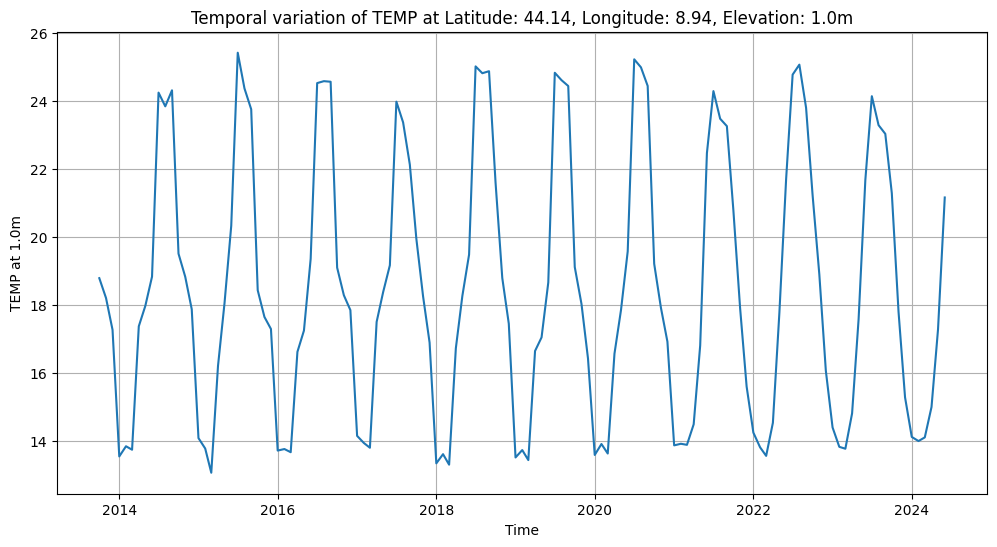

In [ ]:
# @title
# Define variables based on widget selections and map click
if not last_clicked_coordinates:
  last_clicked_coordinates = {
      "lat": -62.51567075588716, 
      "lng": -51.79782956265633
      }

layer = layer_dropdown.value.split('/')[-1]  # Get the last part of the layer name
first_date = time_range_slider.value[0].split('T')[0] # Remove time component
second_date = time_range_slider.value[1].split('T')[0] # Remove time component
selected_elevation = elevation_slider.value
lat = round(last_clicked_coordinates['lat'], 5) # Approximate latitude to 5 decimal places
lon = round(last_clicked_coordinates['lng'], 5) # Approximate longitude to 5 decimal places

# Construct the temporal_url based on the provided structure
temporal_url = (
    f'https://er1.s4oceanice.eu/erddap/griddap/INSITU_GLO_PHY_TS_OA_MY_013_052.csv?'
    f'{layer}%5B({first_date}):1:({second_date})'
    f'%5D%5B({selected_elevation}):1:({selected_elevation})'
    f'%5D%5B({lat}):1:({lat})'
    f'%5D%5B({lon}):1:({lon})%5D'
)


print(f"Fetching data from: {temporal_url}")

# Fetch the data from the temporal_url
try:
    temporal_response = requests.get(temporal_url)
    temporal_response.raise_for_status() # Raise an HTTPError for bad responses (4xx or 5xx)
    temporal_data = temporal_response.text

except requests.exceptions.RequestException as e:
    print(f"Error fetching data from {temporal_url}: {e}")
    temporal_data = None

if temporal_data:

    from io import StringIO

    try:
        df_temporal = pd.read_csv(StringIO(temporal_data), skiprows=[0, 1], delimiter=',') # Skip both header rows and specify delimiter
        # Manually assign column names based on the second header row in the raw data
        # Assuming the order is always time, depth, latitude, longitude, and then the variable (PSAL or TEMP)
        if layer == 'PSAL':
            df_temporal.columns = ['time', 'depth', 'latitude', 'longitude', 'PSAL']
            value_column = 'PSAL'
        elif layer == 'TEMP':
             df_temporal.columns = ['time', 'depth', 'latitude', 'longitude', 'TEMP']
             value_column = 'TEMP'
        else:
             print(f"Unknown layer: {layer}. Cannot determine value column.")
             df_temporal = None

    except pd.errors.ParserError as e:
        print(f"Error parsing CSV data: {e}")
        df_temporal = None


    if df_temporal is not None and not df_temporal.empty:
        time_column = df_temporal.columns[0]

        if df_temporal is not None and value_column in df_temporal.columns:

            df_temporal[time_column] = pd.to_datetime(df_temporal[time_column], errors='coerce')

            # Check if the value column is numeric and convert if necessary
            if not pd.api.types.is_numeric_dtype(df_temporal[value_column]):
                 try:
                     df_temporal[value_column] = pd.to_numeric(df_temporal[value_column], errors='coerce')
                     # print(f"Converted '{value_column}' to numeric.") # Commented out to hide output
                 except ValueError:
                     print(f"Error converting '{value_column}' to numeric.")
                     df_temporal = None # Set to None if conversion fails


            if df_temporal is not None:
                # Drop rows with NaT in either time or value column
                df_temporal.dropna(subset=[time_column, value_column], inplace=True)

                # Plot the data
                if not df_temporal.empty:
                    plt.figure(figsize=(12, 6))
                    # Use line plot for time-series data
                    plt.plot(df_temporal[time_column], df_temporal[value_column])
                    plt.xlabel('Time')
                    plt.ylabel(f'{layer} at {selected_elevation}m')
                    plt.title(f'Temporal variation of {layer} at Latitude: {lat:.2f}, Longitude: {lon:.2f}, Elevation: {selected_elevation}m')
                    plt.grid(True)
                    plt.show()
                else:
                    print("No data available to plot after dropping invalid entries.")

        else:
             print(f"Value column '{value_column}' not found in the DataFrame.")

    else:
        print("No data available to process from the fetched data.")

else:
    print("Could not fetch or process temporal data.")

**7. Depth-Profile Extraction and Plotting at Selected Location (Range of Depths)**

This cell builds a griddap query to ERDDAP for the chosen layer (TEMP or PSAL) at your clicked latitude/longitude, over the selected time range, and across depths 1–5500 m. It then:

* Parses the returned CSV, keeps the value column, and coerces it to numeric.

* Drops invalid rows and plots a depth profile (value vs. depth) with the y-axis inverted.

* Colors the points by the variable value and adds a colorbar for quick interpretation.

**Note:** Run this code once you selected layer, elevation, time range and coordinates by clicking on the map. Also do it everytime you change a selection.


Fetching data from: https://er1.s4oceanice.eu/erddap/griddap/INSITU_GLO_PHY_TS_OA_MY_013_052.csv?TEMP%5B(2013-09-01):1:(2024-06-01)%5D%5B(1):1:(5500)%5D%5B(44.1428):1:(44.1428)%5D%5B(8.9428):1:(8.9428)%5D


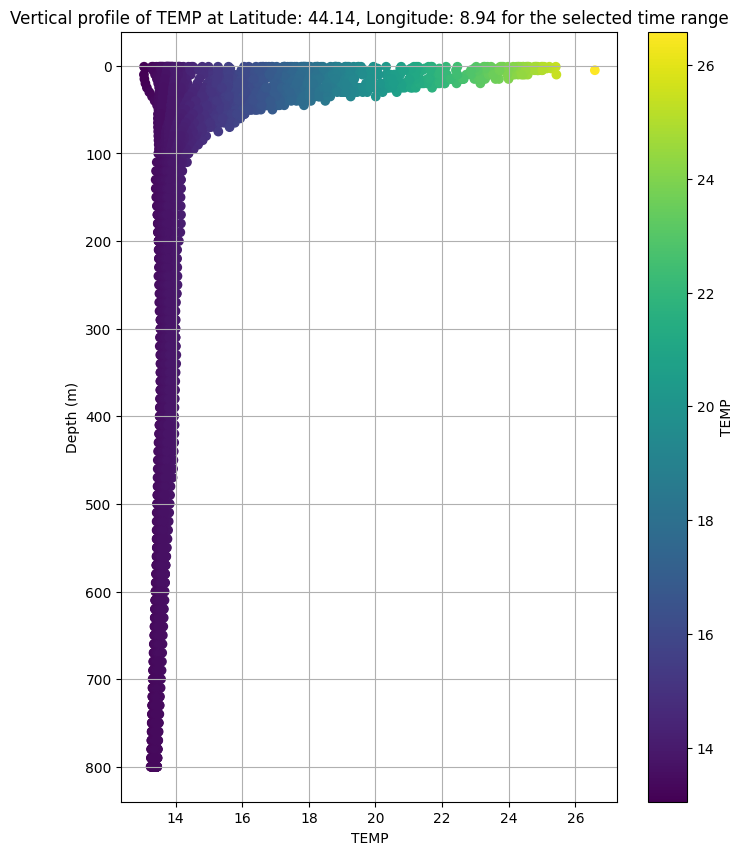

In [ ]:
# @title
# Define variables based on widget selections and map click
if not last_clicked_coordinates:
  last_clicked_coordinates = {
      "lat": -62.51567075588716, 
      "lng": -51.79782956265633
      }

layer = layer_dropdown.value.split('/')[-1]  # Get the last part of the layer name
first_date = time_range_slider.value[0].split('T')[0] # Remove time component
second_date = time_range_slider.value[1].split('T')[0] # Remove time component
selected_elevation = elevation_slider.value
lat = round(last_clicked_coordinates['lat'], 5) # Approximate latitude to 5 decimal places
lon = round(last_clicked_coordinates['lng'], 5) # Approximate longitude to 5 decimal places

depth_url = (
    f'https://er1.s4oceanice.eu/erddap/griddap/INSITU_GLO_PHY_TS_OA_MY_013_052.csv?'
    f'{layer}%5B({first_date}):1:({second_date})'
    f'%5D%5B(1):1:(5500)'
    f'%5D%5B({lat}):1:({lat})'
    f'%5D%5B({lon}):1:({lon})%5D'
)
print(f'Fetching data from: {depth_url}')
# Fetch the data from the depth_url
try:
    depth_response = requests.get(depth_url)
    depth_response.raise_for_status() # Raise an HTTPError for bad responses (4xx or 5xx)
    depth_data = depth_response.text

except requests.exceptions.RequestException as e:
    print(f"Error fetching data from {depth_url}: {e}")
    depth_data = None

if depth_data:

    from io import StringIO

    try:
        df_depth = pd.read_csv(StringIO(depth_data), skiprows=[0, 1], delimiter=',') # Skip both header rows and specify delimiter
        # Manually assign column names based on the second header row in the raw data
        # Assuming the order is always time, depth, latitude, longitude, and then the variable (PSAL or TEMP)
        if layer == 'PSAL':
            df_depth.columns = ['time', 'depth', 'latitude', 'longitude', 'PSAL']
            value_column = 'PSAL'
        elif layer == 'TEMP':
             df_depth.columns = ['time', 'depth', 'latitude', 'longitude', 'TEMP']
             value_column = 'TEMP'
        else:
             print(f"Unknown layer: {layer}. Cannot determine value column.")
             df_depth = None


    except pd.errors.ParserError as e:
        print(f"Error parsing CSV data: {e}")
        df_depth = None


    if df_depth is not None and not df_depth.empty:

        # Check if the value column is numeric and convert if necessary
        if value_column in df_depth.columns and not pd.api.types.is_numeric_dtype(df_depth[value_column]):
             try:
                 df_depth[value_column] = pd.to_numeric(df_depth[value_column], errors='coerce')
                 # print(f"Converted '{value_column}' to numeric.") # Commented out to hide output
             except ValueError:
                 print(f"Error converting '{value_column}' to numeric.")
                 df_depth = None # Set to None if conversion fails


        if df_depth is not None:
            # Drop rows with NaT in the value column
            df_depth.dropna(subset=[value_column], inplace=True)

            # Plot the vertical profile
            if not df_depth.empty:
                plt.figure(figsize=(8, 10))
                # Use the value column for coloring the points
                scatter = plt.scatter(df_depth[value_column], df_depth['depth'], c=df_depth[value_column], cmap='viridis') # Changed to scatter plot and added coloring
                plt.xlabel(f'{layer}')
                plt.ylabel('Depth (m)')
                plt.title(f'Vertical profile of {layer} at Latitude: {lat:.2f}, Longitude: {lon:.2f} for the selected time range')
                plt.gca().invert_yaxis()  # Invert the y-axis to show depth increasing downwards
                plt.grid(True)
                plt.colorbar(scatter, label=f'{layer}') # Add a colorbar
                plt.show()
            else:
                 print("No data available to plot after dropping invalid entries.")

    else:
        print("No data available to process from the fetched data.")

else:
    print("Could not fetch or process depth data.")

This work has received funding from the European Union Horizon Europe project Ocean-Cryosphere Exchanges in ANtarctica: Impacts on Climate and the Earth System (OCEAN ICE) under grant agreement No. 101060452 (https://doi.org/10.3030/101060452). UK partners are funded by UK Research and Innovation (UKRI) under the UK government’s Horizon Europe funding guarantee. 
This notebook makes use of data from the Copernicus Marine Service (https://marine.copernicus.eu).

<center>
  <div style="display: flex; justify-content: center; align-items: flex-start; gap: 20px;">
    <img src="https://ocean-ice.eu/wp-content/uploads/2025/02/TO-USE-RGB-for-digital-materials-V.png" height="100" style="margin-top: 50px;"/>
    <img src="https://ocean-ice.eu/wp-content/uploads/2025/02/UKRI-logo-1.png" height="80"/>
    <img src="https://ocean-ice.eu/wp-content/uploads/2023/06/logo-polar-cluster-2.png" height="80"/>
    <img src="https://www.copernicus.eu/themes/custom/copernicus/img/images/copernicus_eu_logo_white.svg" height="80"/>
  </div>
</center>
